In [1]:
import pandas as pd
import gzip
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
clinical_data_path = '/Users/mohammad.enayet/Documents/Personal/Duke-Dataset/Clinical_and_Other_Features11.xlsx'
features_path = '/Users/mohammad.enayet/Documents/Personal/Duke-Dataset/features_extracted.pkl.gz'

In [4]:
clinical_data = pd.read_excel(clinical_data_path)

# Rename columns for consistency
clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
clinical_data = clinical_data.rename(columns={'Patient_ID': 'patient_id', 'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'})

# Convert 'Breast_MRI_001' to '001' in the patient_id column
clinical_data['patient_id'] = clinical_data['patient_id'].apply(lambda x: x.split('_')[-1] if isinstance(x, str) else x)

# Convert response to binary: 1 or 2 means response, anything other than 1 or 2 means no response
clinical_data['response'] = clinical_data['response'].apply(lambda x: 1 if x in [1, 2] else 0)

In [5]:
clinical_data

,patient_id,Date_of_Birth_(Days),Menopause_(at_diagnosis),Race_and_Ethnicity,ER,PR,HER2,Mol_Subtype,Staging(Nodes),Staging,Multicentric/Multifocal,Contralateral_Breast_Involvement,Lymphadenopathy_or_Suspicious_Nodes,Skin/Nipple_Invovlement,response
0,001,-15209,0,2,0,0,1,2,1,0,0,0,0,0,0
1,002,-14061,0,2,0,0,0,3,0,0,0,0,0,0,1
2,005,-13932,0,5,1,0,1,1,1,0,1,0,1,0,1
3,009,-20541,1,1,0,0,0,3,0,0,1,0,0,0,1
4,010,-24712,1,1,0,0,0,3,2,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,285,-17088,0,2,1,1,0,0,1,0,1,0,0,0,1
101,287,-16980,0,1,1,1,0,0,1,0,1,0,0,0,0
102,290,-14768,0,1,1,1,0,0,1,0,1,1,1,0,0
103,293,-18324,0,1,0,0,0,3,1,-1,1,0,0,1,0


In [6]:
# Load the features from the compressed file

with gzip.open(features_path, 'rb') as f:
    features_without_pyspark = pickle.load(f)

# Extract patient IDs from the keys
features_data = {
    'patient_id': [key.split('-')[0] for key in features_without_pyspark.keys()],
    **{f'feature_{i}': [features_without_pyspark[key][i] for key in features_without_pyspark.keys()] 
       for i in range(len(next(iter(features_without_pyspark.values()))))}
}

# Create a DataFrame for the features
features_df = pd.DataFrame(features_data)

In [10]:
# Ensure 'patient_id' columns are of the same type
features_df['patient_id'] = features_df['patient_id'].astype(str)
clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

# Combine extracted features with clinical data
combined_df = features_df.merge(clinical_data, on='patient_id', how='left')

# Check the combined DataFrame
#print("Combined DataFrame head:")
#print(combined_df.head())

# Check the shape of the combined DataFrame
print(f"Combined DataFrame shape: {combined_df.shape}")

Combined DataFrame shape: (3536, 25103)


In [11]:
combined_df

,patient_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,PR,HER2,Mol_Subtype,Staging(Nodes),Staging,Multicentric/Multifocal,Contralateral_Breast_Involvement,Lymphadenopathy_or_Suspicious_Nodes,Skin/Nipple_Invovlement,response
0,132,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,3,0,-1,0,0,0,0,1
1,285,0.0,0.0,0.0,0.0,0.000000,0.0,4.482966,0.0,0.000000,...,1,0,0,1,0,1,0,0,0,1
2,258,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,3.655285,...,0,0,3,1,0,1,0,1,1,1
3,228,0.0,0.0,0.0,0.0,20.806913,0.0,0.000000,0.0,10.845020,...,1,0,0,1,0,1,0,1,0,0
4,148,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,3.581501,...,0,0,3,2,-1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,198,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1,0,0,2,-1,1,0,1,0,0
3532,148,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,7.647000,...,0,0,3,2,-1,1,0,0,0,0
3533,282,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,3,2,-1,1,0,1,0,0
3534,041,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1,0,0,0,0,0,0,0,0,0


/Users/mohammad.enayet/Documents/Personal/Duke-Dataset/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohammad.enayet/Documents/Personal/Duke-Dataset/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Logistic Regression validation accuracy: 0.7975
Logistic Regression test accuracy: 0.8281
Logistic Regression precision: 0.7151
Logistic Regression recall: 0.8526
Logistic Regression F1 score: 0.7778
Logistic Regression AUROC: 0.8946
Logistic Regression training time: 3.7073 seconds
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


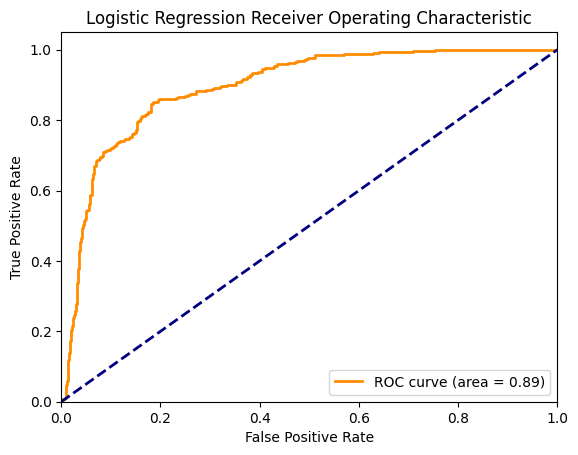

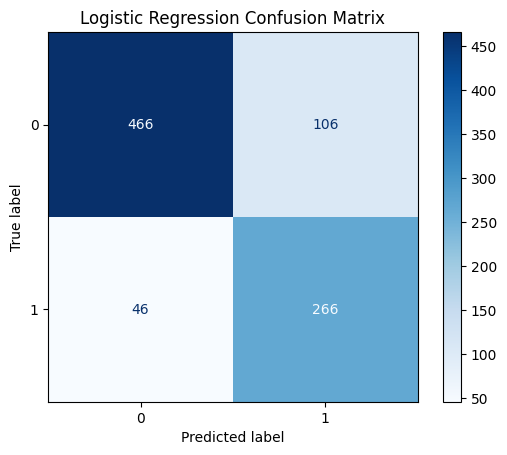

True Positives: 266
False Positives: 106
True Negatives: 466
False Negatives: 46


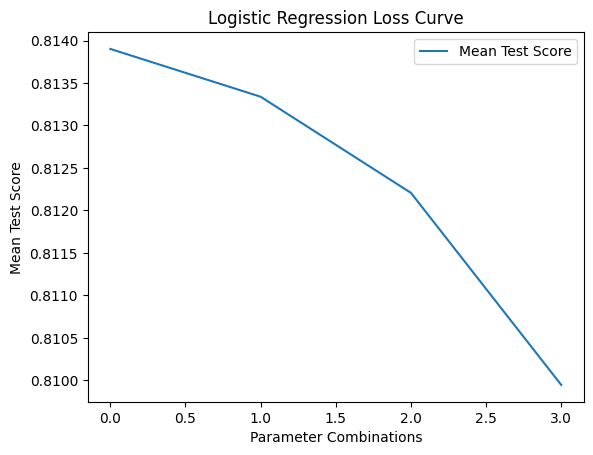

Random Forest validation accuracy: 0.9898
Random Forest test accuracy: 0.9887
Random Forest precision: 1.0000
Random Forest recall: 0.9679
Random Forest F1 score: 0.9837
Random Forest AUROC: 1.0000
Random Forest training time: 3.6648 seconds
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 50}


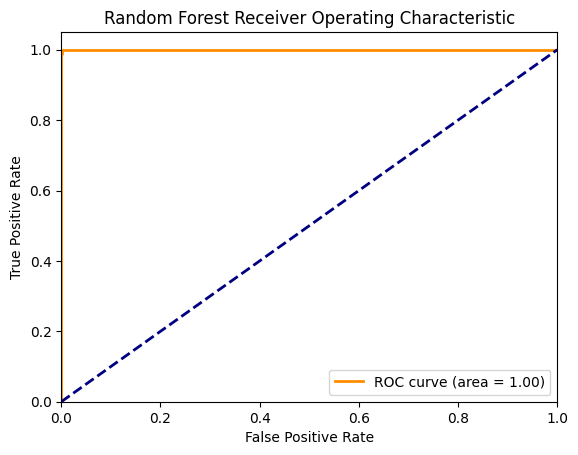

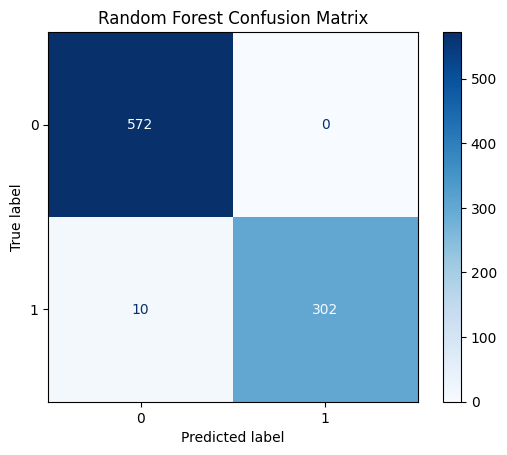

True Positives: 302
False Positives: 0
True Negatives: 572
False Negatives: 10


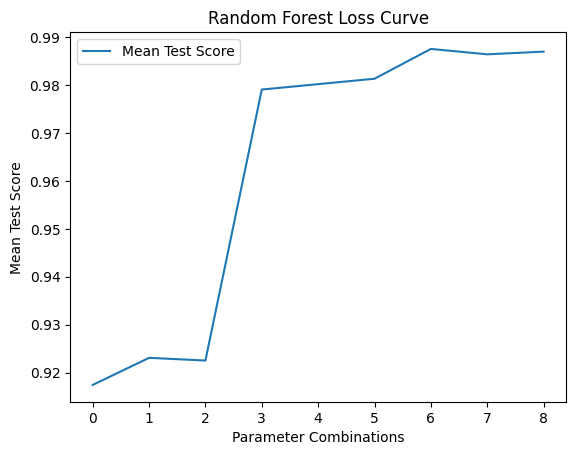

Gradient Boosted Trees validation accuracy: 0.9943
Gradient Boosted Trees test accuracy: 0.9977
Gradient Boosted Trees precision: 1.0000
Gradient Boosted Trees recall: 0.9936
Gradient Boosted Trees F1 score: 0.9968
Gradient Boosted Trees AUROC: 1.0000
Gradient Boosted Trees training time: 49.3453 seconds
Best parameters for Gradient Boosted Trees: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


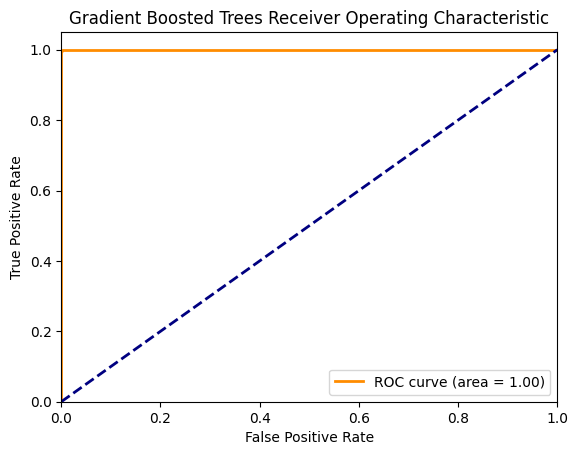

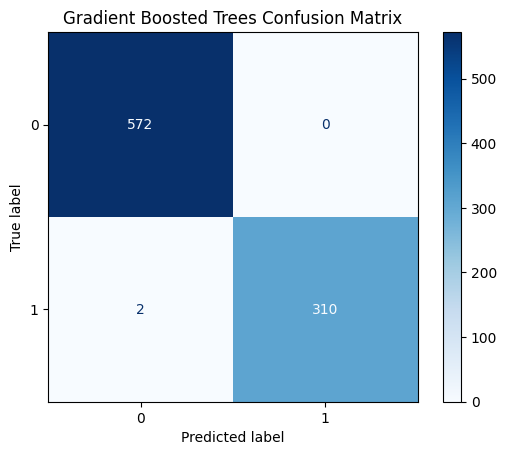

True Positives: 310
False Positives: 0
True Negatives: 572
False Negatives: 2


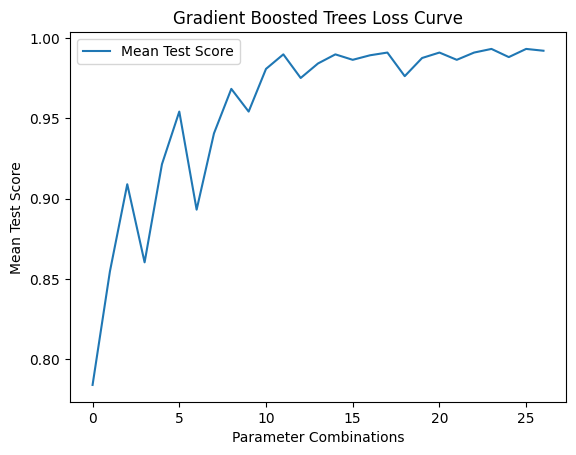

XGBoost validation accuracy: 0.9932
XGBoost test accuracy: 0.9977
XGBoost precision: 0.9968
XGBoost recall: 0.9968
XGBoost F1 score: 0.9968
XGBoost AUROC: 1.0000
XGBoost training time: 7.0525 seconds
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


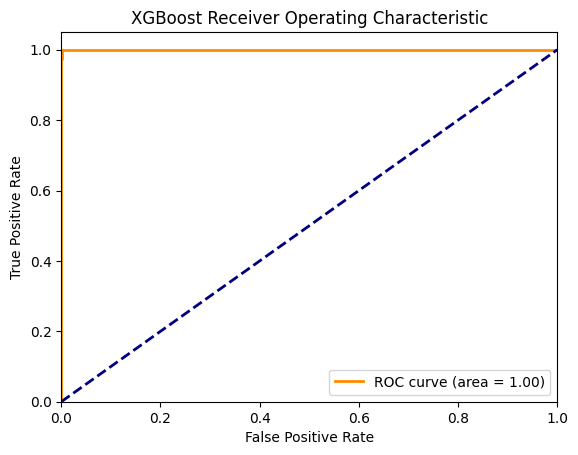

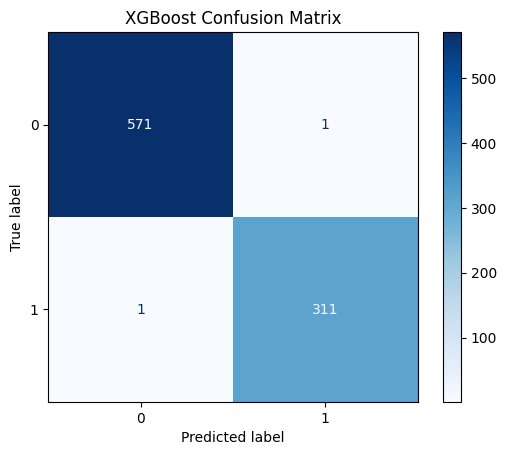

True Positives: 311
False Positives: 1
True Negatives: 571
False Negatives: 1


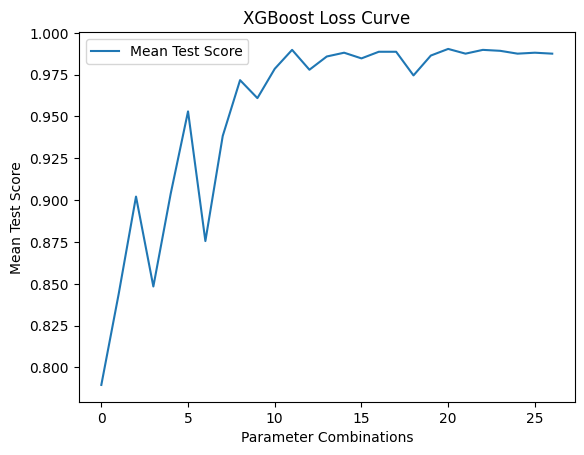

[LightGBM] [Info] Number of positive: 409, number of negative: 769
[LightGBM] [Info] Number of positive: 409, number of negative: 770
[LightGBM] [Info] Number of positive: 409, number of negative: 770
[LightGBM] [Info] Number of positive: 410, number of negative: 769
[LightGBM] [Info] Number of positive: 410, number of negative: 769
[LightGBM] [Info] Number of positive: 409, number of negative: 769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Total Bins 8925
[LightGBM]

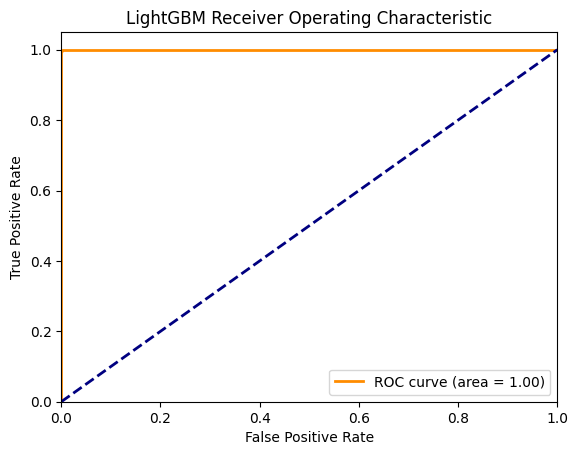

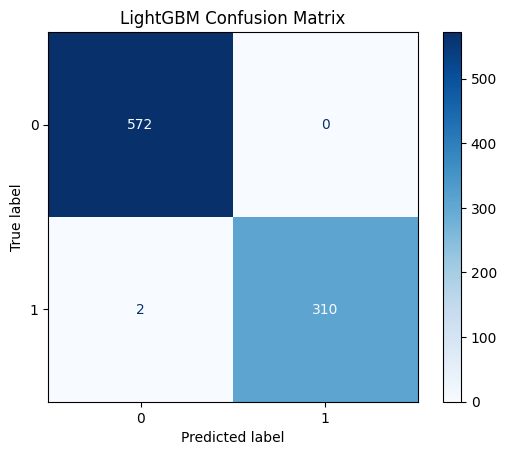

True Positives: 310
False Positives: 0
True Negatives: 572
False Negatives: 2


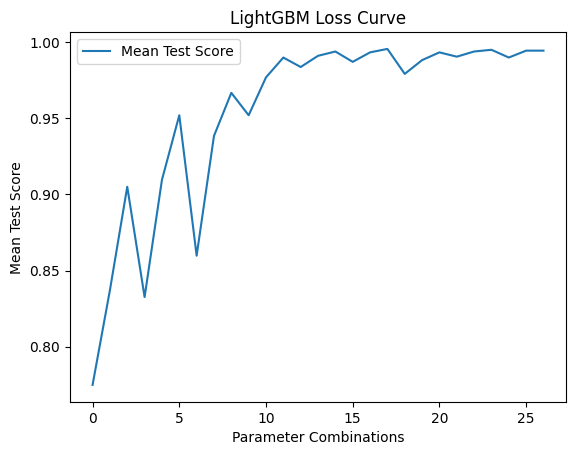

LGBMClassifier(max_depth=7, n_estimators=200)

In [13]:
# Assuming combined_df is your DataFrame
# Separate features and target
X = combined_df.drop(columns=['patient_id', 'response'])
y = combined_df['response']

# Perform PCA
pca = PCA(n_components=35)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.5, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=22)

def plot_auroc(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

def plot_loss_curve(grid_result, model_name):
    mean_test_score = grid_result.cv_results_['mean_test_score']
    plt.figure()
    plt.plot(mean_test_score, label='Mean Test Score')
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Mean Test Score')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.show()

def train_and_evaluate(model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    
    start_time = time.time()
    grid_result = grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_model = grid_result.best_estimator_
    
    # Validation Performance
    y_val_pred = best_model.predict(X_val)
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Test Performance
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auroc = roc_auc_score(y_test, y_test_proba)
    
    print(f"{model_name} validation accuracy: {val_accuracy:.4f}")
    print(f"{model_name} test accuracy: {test_accuracy:.4f}")
    print(f"{model_name} precision: {precision:.4f}")
    print(f"{model_name} recall: {recall:.4f}")
    print(f"{model_name} F1 score: {f1:.4f}")
    print(f"{model_name} AUROC: {auroc:.4f}")
    print(f"{model_name} training time: {training_time:.4f} seconds")
    print(f"Best parameters for {model_name}: {grid_result.best_params_}")
    
    plot_auroc(y_test, y_test_proba, model_name)
    plot_confusion_matrix(y_test, y_test_pred, model_name)
    plot_loss_curve(grid_result, model_name)
    
    return best_model

# Logistic Regression
lr = LogisticRegression(max_iter=100)
param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
train_and_evaluate(lr, param_grid_lr, X_train, y_train, X_val, y_val, X_test, y_test, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
train_and_evaluate(rf, param_grid_rf, X_train, y_train, X_val, y_val, X_test, y_test, "Random Forest")

# Gradient Boosted Trees
gbt = GradientBoostingClassifier()
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
train_and_evaluate(gbt, param_grid_gbt, X_train, y_train, X_val, y_val, X_test, y_test, "Gradient Boosted Trees")

## Support Vector Machine
#svm = SVC(probability=True)
#param_grid_svm = {
#    'C': [0.01, 0.1, 1.0, 10.0],
#    'kernel': ['linear', 'rbf']
#}
#train_and_evaluate(svm, param_grid_svm, X_train, y_train, X_val, y_val, X_test, y_test, "Support Vector Machine")

# XGBoost
xgb_model = xgb.XGBClassifier()
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
train_and_evaluate(xgb_model, param_grid_xgb, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost")

# LightGBM
lgb_model = lgb.LGBMClassifier()
param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
train_and_evaluate(lgb_model, param_grid_lgb, X_train, y_train, X_val, y_val, X_test, y_test, "LightGBM")
